In [1]:
%matplotlib inline
import seaborn as sns
import numpy as np
from collections import *
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import itertools
import networkx as nx

# Intro

This is a very simple mock-up of our proposed campgaining plattform vandr. The idea is that users, such as ourselves, add their friends etc. The plattform aims to mobilise ze users ($sic$) to donate money, participate in the official campgain etc. In the very simple mock-up, there is a a $k$ probability for a each user to add a new user. This mean drawing a random number, $r$ between 0 and 1 for each user. If $k > r$, the move is accepted. Other actions such as donating money or campagaining activities will also be modelled as a rate process, which I can add. Users gain points when the add their friends and participate in the campgain. 


So far I have only included points the users made themselves and added $1/10$ of the points of the users they added themselves. As dicussed, I should addd to the primay points and first-generation points, $1/100$ of the second generation points. vandr - let's win that shit again!

# Quick simulation to generate data

## Function definitions

In [2]:
def try_add_players(player_dict,current_time, k_ar, r_ar, sponentous=False):
    """
    Try and accept steps for each player. Update the dictionary that
    keeps track of the players.
    
    New players could also start to use vandr on their own, which I 
    have not considered yet.
    """
    # plyer_dict must be adefault dict with list so that we can track all the actions of 
    # a player
    new_index = np.max(player_dict.keys()) +1
    
    for k,v in player_dict.items():
        #if r_ar[k,0] >= r_ar[k,current_time]:
        if k_ar[k] >= r_ar[k, current_time]:
            if not sponentous:
                #player_dict[k]['added'][new_index] = current_time
                _temp_dict = player_dict[k]
                _prev = None
                if _temp_dict['added'].keys():
                    _prev_time = np.max(_temp_dict['added'].keys())
                    _prev = _temp_dict['added'][_prev_time]
                #else:
                #    _prev =[0]
                if _prev:
                    player_dict[k]['added'][current_time] = _prev + [new_index]
                else:
                    player_dict[k]['added'][current_time] = [new_index]
                #new_index + player_dict[k]['added'][np.max(player_dict[k]['added'].keys())]
            player_dict[new_index] = defaultdict(start_time=current_time,added={})
            new_index = new_index + 1
    return player_dict        

In [3]:
def setup_sim(n_inital_players=3):
    player_dict = defaultdict()
    for n in range(n_inital_players):
        player_dict[n] = defaultdict(start_time=0, added={})
    return player_dict
    
def run_sim(total_steps, total_number_players, player_dict, verbose=False):
    for time_step in range(total_steps-1):
        if verbose:
            print time_step, len(player_dict.keys())
        if len(player_dict.keys()) < total_number_players:
            _player_dict = try_add_players(deepcopy(player_dict), time_step, k_ar, r_ar)
            if len(_player_dict.keys()) > total_number_players:
                break
            else:
                 player_dict = _player_dict
                    
    return player_dict

def setup_run_sim(total_steps, total_number_players, n_inital_players=3, verbose=False):
    player_dict = setup_sim(n_inital_players=n_inital_players)
    player_dict = run_sim(total_steps, total_number_players, player_dict, verbose=verbose)
    return player_dict

In [4]:
def calc_primary_score(player_dict, total_steps, total_number_players):
    _temp_ar = np.zeros((total_steps, total_number_players))
    #print _temp_ar.shape
    for key, value in player_dict.items():
        if value:
            #print key
            for t in range(total_steps - 1):
                if t in value['added'].keys():
                    _temp_ar[t,key] = len(value['added'][t]) -1
                elif t > 0 and (t < total_steps ):
                    _temp_ar[t,key] = _temp_ar[t-1,key]
    return _temp_ar

In [5]:
def calc_secondary_score(player_dict, total_steps, total_number_players, p_score_ar,
                        weight_factor = 0.1, verbose=False):
    _secondary_ar = np.zeros((total_steps, total_number_players))
    for key, value in player_dict.items():
        if value:
            for t in range(total_steps -1 ):
                if t in value['added'].keys():
                    _added_at_t = value['added'][t]
                    _first_gen_l = []
                    if verbose:
                        print _added_at_t
                    for added_player in _added_at_t:
                        _first_gen_l.append(p_score_ar[t,added_player])
                    _secondary_ar[t,key] = np.sum(_first_gen_l) * weight_factor
                else:
                    _secondary_ar[t,key] = _secondary_ar[t-1, key]
    return _secondary_ar

In [6]:
def plot_scores_per_player(p_score_ar, s_score_ar):
    fig, ax = plt.subplots()
    palette = itertools.cycle(sns.color_palette())
    for i in range(len(p_score_ar[0,:])):
        _cl = next(palette)
        plt.plot(p_score_ar[:,i] + s_score_ar[:,i],"--", c=_cl )
        plt.plot(p_score_ar[:,i],"-", c=_cl )
    return fig, ax
    

In [7]:
def total_players_over_time(player_dict, last_time):
    player_time_l = []
    for t in range(last_time):
        _counter = 0
        for key, value in player_dict.items():
            if value['start_time'] < t:
                _counter = _counter + 1
        player_time_l.append(_counter)
    return player_time_l

In [8]:
def calc_network(player_dict, time_point=-1):
    '''
    time_point: -1 last time for each player; not used yet
    '''
    VD = nx.DiGraph()
    for key, values in player_dict.items():
        if values['added']:
            _temp = values['added']
            _last_entry = np.max(_temp.keys())
            # print _temp[_last_entry]
            for _added in _temp[_last_entry]:
                VD.add_edge(key, _added)
    return VD



## Simulation of vandr
Ok, let's run a simple simulation of vandr!

In [9]:
k=0.1
total_steps = 500
total_number_players = 500 # there is a bug atm, total_steps==total_number_players
# in principle limited to ~8.5x10^6 ;-)

In [10]:
np.random.seed(0) # if we want to fix random number seed for a start
r_ar = np.random.random((total_steps, total_number_players))
k_ar = np.array([k]*total_number_players) # uniform rates for each player

In [11]:
_dict = setup_run_sim(total_steps, total_number_players)
_p = calc_primary_score(_dict, total_steps, total_number_players)
_s = calc_secondary_score(_dict, total_steps, total_number_players, _p)


Total number of players that participated

In [12]:
_dict.keys().__len__()

477

simulation stooped at

In [13]:
last_time = _dict[np.max(_dict.keys())]['start_time']
last_time

52

# Visualisation
## Points made

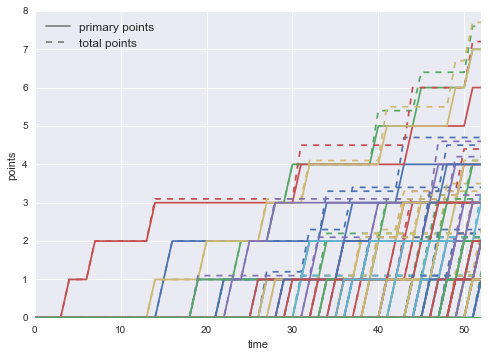

In [14]:
fig, ax = plot_scores_per_player(_p, _s)
plt.plot(0,0, c='gray', label="primary points")
plt.plot(0,0, '--',  c='gray',label="total points")
plt.legend(loc=2, fontsize=12)
plt.xlim(0,last_time)
plt.ylabel('points')
plt.xlabel('time')

In this small network primary points unsurprisingly dominate. N.B. other actions such as donating money or campgaining are missing and these will really drive up the scondary points. 

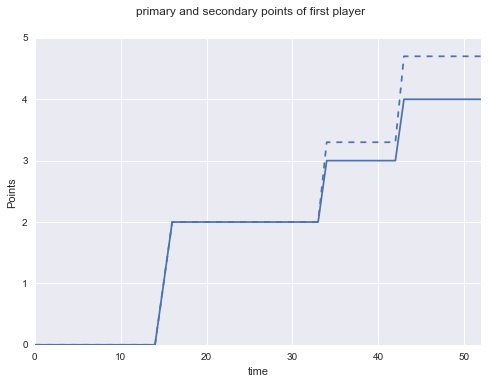

In [15]:
fig, ax = plot_scores_per_player(_p[:-1,:1], _s[:-1,:1])
ax.set_xlim(0,last_time)
plt.suptitle("primary and secondary points of first player")
plt.ylabel("Points")
plt.xlabel("time")

## Number of players

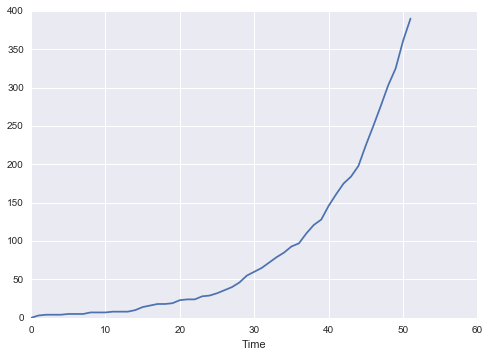

In [16]:
player_time_l = total_players_over_time(_dict, last_time)
fig, ax  = plt.subplots()
ax.plot(player_time_l, label='number of players')
plt.xlabel('Time')

## The network

Networks can visualised and plotted based on the dictionary object that contains the relationship between the players. 

A very simple illustration of the network at the end of simulation

In [17]:
cl = sns.color_palette()

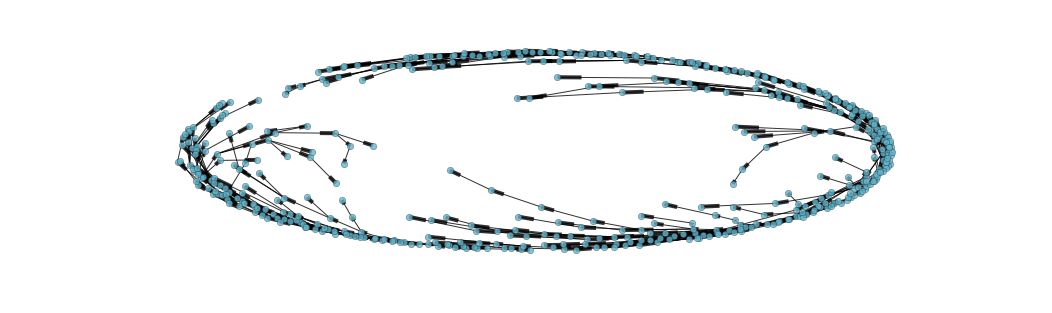

In [18]:
fig, ax = plt.subplots(figsize=(18,5))

VD = calc_network(_dict)
nx.draw(VD, ax=ax, node_color=cl[5], alpha=0.8, node_size=42)

# Data structure

A quick look at the data structure, looking at player 0. Data is organised as dictionaries. When a new connection is made the total list of connection made by a player is udated. In this way, the history of the network is retained. I am sure this could be done much more elegantly.

The start time of the player is also loggged. I can added new entries into the dictionary, such as money raised.

I need to think about the databases e.g MongoDB, which could actually use.

In [19]:
_dict[1]

defaultdict(None,
            {'added': {7: [5],
              22: [5, 24],
              24: [5, 24, 29],
              28: [5, 24, 29, 46],
              30: [5, 24, 29, 46, 60],
              40: [5, 24, 29, 46, 60, 146],
              45: [5, 24, 29, 46, 60, 146, 225],
              51: [5, 24, 29, 46, 60, 146, 225, 390]},
             'start_time': 0})

# Next steps

(note to myself)

The mock-up, once extended can be used to think about the scoring system. We could play with scoring system to see whether we get reasonable results. How far should the points be dominated by donations? As discussed, larger donations should be weighted less. 